[![Roboflow Notebooks](https://media.roboflow.com/notebooks/template/bannertest2-2.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672932710194)](https://github.com/roboflow/notebooks)

# How to Train YOLOv12 Object Detection on a Custom Dataset

---

[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/roboflow-ai/notebooks/blob/main/notebooks/train-yolov12-object-detection-model.ipynb)
[![arXiv](https://img.shields.io/badge/arXiv-2502.12524-b31b1b.svg)](https://arxiv.org/abs/2502.12524)
[![Roboflow](https://raw.githubusercontent.com/roboflow-ai/notebooks/main/assets/badges/roboflow-blogpost.svg)](https://blog.roboflow.com/train-yolov12-model)
[![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/sunsmarterjie/yolov12)

[YOLOv12](https://github.com/sunsmarterjie/yolov12) is a newly proposed attention-centric variant of the YOLO family that focuses on incorporating efficient attention mechanisms into the backbone while preserving real-time performance. Instead of relying heavily on CNN-based architectures like its predecessors, YOLOv12 introduces a simple yet powerful “area attention” module, which strategically partitions the feature map to reduce the quadratic complexity of full self-attention. It also adopts residual efficient layer aggregation networks (R-ELAN) to enhance feature aggregation and training stability, especially for larger models. These innovations, together with refinements such as scaled residual connections and a reduced MLP ratio, enable YOLOv12 to harness the benefits of attention (e.g., better global context modeling) without sacrificing speed.

![yolov12-area-attention](https://media.roboflow.com/notebooks/examples/yolov12-area-attention.png)

Compared to prior YOLO iterations (e.g., YOLOv10, YOLOv11, and YOLOv8), YOLOv12 achieves higher detection accuracy with competitive or faster inference times across all model scales. Its five sizes—N, S, M, L, and X—range from 2.6M to 59.1M parameters, striking a strong accuracy–speed balance. For instance, the smallest YOLOv12-N surpasses other “nano” models by over 1% mAP with latency around 1.6 ms on a T4 GPU, and the largest YOLOv12-X achieves 55.2% mAP, comfortably outscoring comparable real-time detectors such as RT-DETR and YOLOv11-X . By matching or exceeding state-of-the-art accuracy while remaining fast, YOLOv12 represents a notable step forward for attention-based real-time object detection.

![yolov12-metrics](https://storage.googleapis.com/com-roboflow-marketing/notebooks/examples/yolov12-metrics.png)

## Environment setup

### Configure your API keys

To fine-tune YOLOv12, you need to provide your Roboflow API key. Follow these steps:

- Go to your [`Roboflow Settings`](https://app.roboflow.com/settings/api) page. Click `Copy`. This will place your private key in the clipboard.
- In Colab, go to the left pane and click on `Secrets` (🔑). Store Roboflow API Key under the name `ROBOFLOW_API_KEY`.

In [3]:
import os
from google.colab import userdata

os.environ["ROBOFLOW_API_KEY"] = userdata.get("ROBOFLOW_API_KEY")

### Check GPU availability

**NOTE:** **YOLOv12 leverages FlashAttention to speed up attention-based computations, but this feature requires an Nvidia GPU built on the Ampere architecture or newer—for example, GPUs like the RTX 3090, RTX 3080, or even the Nvidia L4 meet this requirement.**

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [4]:
!nvidia-smi

Mon Mar 10 21:28:30 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   38C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [5]:
import os
HOME = os.getcwd()
print(HOME)

/content


### Install dependencies

**NOTE:** Currently, YOLOv12 does not have its own PyPI package, so we install it directly from GitHub while also adding roboflow (to conveniently pull datasets from the Roboflow Universe), supervision (to visualize inference results and benchmark the model’s performance), and flash-attn (to accelerate attention-based computations via optimized CUDA kernels).

In [6]:
!pip install -q git+https://github.com/sunsmarterjie/yolov12.git roboflow supervision flash-attn

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 72.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.3/83.3 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 67.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 35.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━

### Download example data

Let's download an image we can use for YOLOv12 inference. Feel free to drag and drop your own images into the Files tab on the left-hand side of Google Colab, then reference their filenames in your code for a custom inference demo.

In [7]:
!wget https://media.roboflow.com/notebooks/examples/dog.jpeg

--2025-03-10 21:30:48--  https://media.roboflow.com/notebooks/examples/dog.jpeg
Resolving media.roboflow.com (media.roboflow.com)... 34.110.133.209
Connecting to media.roboflow.com (media.roboflow.com)|34.110.133.209|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 106055 (104K) [image/jpeg]
Saving to: ‘dog.jpeg’

dog.jpeg            100%[===================>] 103.57K  --.-KB/s    in 0.001s  

2025-03-10 21:30:48 (100 MB/s) - ‘dog.jpeg’ saved [106055/106055]



## Run inference

In the example, we're using the `yolov12l.pt` model, but you can experiment with different model sizes by simply swapping out the model name during initialization. Options include `yolov12n.pt`, `yolov12s.pt`, `yolov12m.pt`, `yolov12l.pt`, and `yolov12x.pt`.

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/yolov12/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
FlashAttention is not available on this device. Using scaled_dot_product_attention instead.


100%|██████████| 51.4M/51.4M [00:00<00:00, 98.5MB/s]


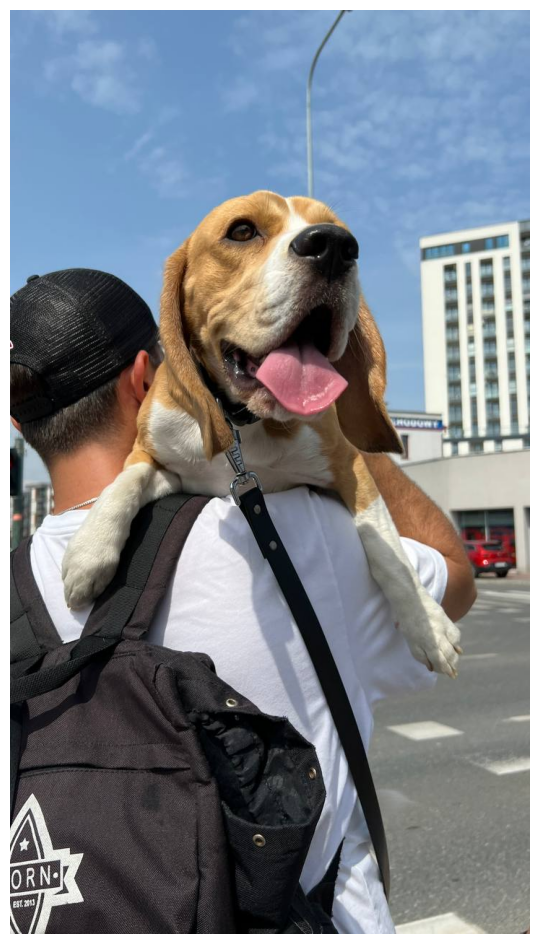

In [8]:
import cv2
from ultralytics import YOLO
import supervision as sv


image_path = f"{HOME}/dog.jpeg"
image = cv2.imread(image_path)

model = YOLO('yolov12l.pt')

results = model(image, verbose=False)[0]
detections = sv.Detections.from_ultralytics(results)

box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

annotated_image = image.copy()
annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections)
annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

sv.plot_image(annotated_image)

## Download dataset from Roboflow Universe

In [10]:
from roboflow import download_dataset

dataset = download_dataset('https://app.roboflow.com/adlul-islam-s3ijv/skin_wound/2', 'yolov8')

loading Roboflow workspace...
loading Roboflow project...
Exporting format yolov8 in progress : 85.0%
Version export complete for yolov8 format



Extracting Dataset Version Zip to Skin_wound-2 in yolov8:: 100%|██████████| 2680/2680 [00:00<00:00, 5875.14it/s]


In [11]:
!ls {dataset.location}

data.yaml  README.dataset.txt  README.roboflow.txt  test  train  valid


**NOTE:** We need to make a few changes to our downloaded dataset so it will work with YOLOv12. Run the following bash commands to prepare your dataset for training by updating the relative paths in the `data.yaml` file, ensuring it correctly points to the subdirectories for your dataset's `train`, `test`, and `valid` subsets.

In [12]:
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!echo -e "test: ../test/images\ntrain: ../train/images\nval: ../valid/images" >> {dataset.location}/data.yaml

In [13]:
!cat {dataset.location}/data.yaml

names:
- Category-1
- Category-3
nc: 2
roboflow:
  license: CC BY 4.0
  project: skin_wound
  url: https://universe.roboflow.com/adlul-islam-s3ijv/skin_wound/dataset/2
  version: 2
test: ../test/images
train: ../train/images
val: ../valid/images


## Fine-tune YOLOv12 model

We are now ready to fine-tune our YOLOv12 model. In the code below, we initialize the model using a starting checkpoint—here, we use `yolov12s.yaml`, but you can replace it with any other model (e.g., `yolov12n.pt`, `yolov12m.pt`, `yolov12l.pt`, or `yolov12x.pt`) based on your preference. We set the training to run for 100 epochs in this example; however, you should adjust the number of epochs along with other hyperparameters such as batch size, image size, and augmentation settings (scale, mosaic, mixup, and copy-paste) based on your hardware capabilities and dataset size.

**Note:** **Note that after training, you might encounter a `TypeError: argument of type 'PosixPath' is not iterable error` — this is a known issue, but your model weights will still be saved, so you can safely proceed to running inference.**

In [14]:
from ultralytics import YOLO

model = YOLO('yolov12s.yaml')

results = model.train(data=f'{dataset.location}/data.yaml', epochs=100)

New https://pypi.org/project/ultralytics/8.3.87 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.63 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov12s.yaml, data=/content/Skin_wound-2/data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, sav

100%|██████████| 755k/755k [00:00<00:00, 27.3MB/s]


Overriding model.yaml nc=80 with nc=2

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1      9344  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2, 1, 2]          
  2                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  3                  -1  1     37120  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2, 1, 4]        
  4                  -1  1    103360  ultralytics.nn.modules.block.C3k2            [128, 256, 1, False, 0.25]    
  5                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
  6                  -1  2    677120  ultralytics.nn.modules.block.A2C2f           [256, 256, 2, True, 4]        
  7                  -1  1   1180672  ultralytics

100%|██████████| 5.26M/5.26M [00:00<00:00, 99.0MB/s]


AMP: checks passed ✅


train: Scanning /content/Skin_wound-2/train/labels... 1170 images, 87 backgrounds, 0 corrupt: 100%|██████████| 1170/1170 [00:00<00:00, 2473.93it/s]

train: New cache created: /content/Skin_wound-2/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


Argument(s) 'quality_lower' are not valid for transform ImageCompression
val: Scanning /content/Skin_wound-2/valid/labels... 82 images, 19 backgrounds, 0 corrupt: 100%|██████████| 82/82 [00:00<00:00, 1997.10it/s]

val: New cache created: /content/Skin_wound-2/valid/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 121 weight(decay=0.0), 128 weight(decay=0.0005), 127 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      6.94G      3.136      4.135      4.129          6        640: 100%|██████████| 74/74 [00:41<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.32it/s]

                   all         82         71   0.000973      0.359    0.00364    0.00135



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      6.89G      3.057      3.699      3.686          6        640: 100%|██████████| 74/74 [00:38<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.40it/s]

                   all         82         71   0.000259     0.0333   0.000323   0.000115



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100       6.9G      2.763      3.332      3.383          4        640: 100%|██████████| 74/74 [00:38<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.90it/s]

                   all         82         71     0.0133       0.16    0.00915     0.0024



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      6.89G      2.603      3.204      3.237          3        640: 100%|██████████| 74/74 [00:38<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.85it/s]

                   all         82         71      0.521     0.0244    0.00867    0.00117



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      6.91G      2.552      3.122      3.133          2        640: 100%|██████████| 74/74 [00:38<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.78it/s]

                   all         82         71     0.0905      0.224     0.0236    0.00495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      6.89G      2.485      2.931      3.013          4        640: 100%|██████████| 74/74 [00:39<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.56it/s]

                   all         82         71     0.0458      0.199     0.0512     0.0147



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      6.91G      2.426      2.835      2.923          3        640: 100%|██████████| 74/74 [00:38<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.89it/s]

                   all         82         71     0.0886      0.146     0.0819     0.0239



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      6.89G      2.345      2.773      2.846          5        640: 100%|██████████| 74/74 [00:38<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.95it/s]

                   all         82         71      0.124      0.237      0.122     0.0289



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      6.91G      2.253      2.711      2.753          6        640: 100%|██████████| 74/74 [00:38<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.89it/s]

                   all         82         71     0.0699      0.193     0.0421     0.0133



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      6.89G      2.232      2.698      2.708          8        640: 100%|██████████| 74/74 [00:39<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.90it/s]

                   all         82         71       0.34      0.187      0.165     0.0491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100       6.9G      2.204      2.667      2.645          1        640: 100%|██████████| 74/74 [00:38<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.42it/s]

                   all         82         71      0.132        0.3       0.13     0.0463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      6.89G      2.168      2.555      2.592          3        640: 100%|██████████| 74/74 [00:38<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.87it/s]

                   all         82         71      0.265      0.219      0.173      0.073



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      6.91G      2.122      2.546      2.568          8        640: 100%|██████████| 74/74 [00:38<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.88it/s]

                   all         82         71      0.218      0.222      0.149     0.0525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      6.91G      2.095      2.498      2.548          2        640: 100%|██████████| 74/74 [00:38<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.88it/s]

                   all         82         71      0.226      0.366      0.171     0.0474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100       6.9G      2.098      2.501      2.514          3        640: 100%|██████████| 74/74 [00:39<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.20it/s]

                   all         82         71       0.22      0.256      0.158     0.0526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      6.88G      2.055      2.449      2.492          4        640: 100%|██████████| 74/74 [00:38<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.90it/s]

                   all         82         71       0.23      0.296      0.193     0.0784



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100       6.9G      2.006       2.41      2.427          2        640: 100%|██████████| 74/74 [00:39<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.89it/s]

                   all         82         71      0.309      0.205      0.177     0.0603



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      6.89G      1.967      2.369      2.446          4        640: 100%|██████████| 74/74 [00:39<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.91it/s]

                   all         82         71      0.193      0.224      0.135     0.0491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      6.91G      1.971      2.411      2.423          1        640: 100%|██████████| 74/74 [00:39<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.43it/s]

                   all         82         71      0.237      0.277      0.154     0.0556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100       6.9G      1.901      2.307      2.355          7        640: 100%|██████████| 74/74 [00:39<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.83it/s]

                   all         82         71      0.183      0.273      0.153     0.0547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      6.94G      1.939      2.293      2.369          4        640: 100%|██████████| 74/74 [00:38<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.82it/s]

                   all         82         71      0.149       0.37       0.17     0.0631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      6.89G      1.933      2.282      2.377          4        640: 100%|██████████| 74/74 [00:39<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.95it/s]

                   all         82         71      0.252      0.305      0.205     0.0785



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      6.91G      1.904       2.31      2.344          4        640: 100%|██████████| 74/74 [00:38<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.53it/s]

                   all         82         71      0.304      0.434       0.32      0.124



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      6.89G      1.878      2.214      2.314          4        640: 100%|██████████| 74/74 [00:39<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.91it/s]

                   all         82         71      0.208      0.357      0.249      0.102



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      6.92G      1.863      2.235      2.297          1        640: 100%|██████████| 74/74 [00:39<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.83it/s]

                   all         82         71      0.236      0.424      0.219     0.0976



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      6.89G      1.865      2.169      2.315          3        640: 100%|██████████| 74/74 [00:39<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.92it/s]

                   all         82         71      0.225      0.348      0.256      0.107



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      6.91G      1.835      2.213      2.274          8        640: 100%|██████████| 74/74 [00:38<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.78it/s]

                   all         82         71      0.284      0.421      0.309       0.12



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      6.89G       1.84      2.205      2.274          5        640: 100%|██████████| 74/74 [00:39<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.88it/s]

                   all         82         71      0.436      0.254      0.326       0.13



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      6.91G      1.816      2.187      2.253          2        640: 100%|██████████| 74/74 [00:39<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.89it/s]

                   all         82         71      0.283      0.431      0.291      0.119



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      6.89G      1.828      2.141      2.245          6        640: 100%|██████████| 74/74 [00:39<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.94it/s]

                   all         82         71      0.245      0.413      0.294      0.119



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      6.91G      1.801      2.122      2.211          3        640: 100%|██████████| 74/74 [00:39<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.78it/s]

                   all         82         71      0.263      0.443      0.278      0.102



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      6.89G      1.837      2.086      2.244          4        640: 100%|██████████| 74/74 [00:38<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.86it/s]

                   all         82         71       0.34      0.448      0.388      0.149



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100       6.9G      1.787      2.095      2.229          6        640: 100%|██████████| 74/74 [00:39<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.88it/s]

                   all         82         71      0.322      0.437      0.326      0.142



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      6.89G      1.776      2.071      2.201          7        640: 100%|██████████| 74/74 [00:38<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.92it/s]

                   all         82         71      0.321      0.419      0.338      0.129



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100       6.9G      1.788      2.058       2.22          1        640: 100%|██████████| 74/74 [00:38<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.68it/s]

                   all         82         71      0.345      0.485      0.386      0.171



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      6.89G      1.776      2.045      2.205          3        640: 100%|██████████| 74/74 [00:38<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.93it/s]

                   all         82         71      0.544      0.412      0.424       0.13



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      6.91G      1.754       2.01      2.165          5        640: 100%|██████████| 74/74 [00:39<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.96it/s]

                   all         82         71      0.368      0.556      0.396      0.164



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100       6.9G      1.749      1.957      2.156          1        640: 100%|██████████| 74/74 [00:38<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.91it/s]

                   all         82         71      0.356      0.539      0.386      0.156



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100       6.9G      1.759       1.98      2.169          7        640: 100%|██████████| 74/74 [00:38<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.86it/s]

                   all         82         71      0.483      0.498      0.504      0.197



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      6.89G      1.744      1.958      2.156          8        640: 100%|██████████| 74/74 [00:39<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.50it/s]

                   all         82         71      0.412      0.452      0.445      0.181



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100       6.9G       1.74      1.955      2.143          6        640: 100%|██████████| 74/74 [00:39<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.90it/s]

                   all         82         71      0.407       0.48      0.392      0.143



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      6.89G      1.748      1.944      2.152          5        640: 100%|██████████| 74/74 [00:38<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.91it/s]

                   all         82         71      0.437      0.511      0.416      0.162



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100       6.9G      1.746      1.982      2.149          4        640: 100%|██████████| 74/74 [00:38<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.94it/s]

                   all         82         71      0.378      0.513      0.348      0.118



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      6.89G      1.701      1.931      2.104          6        640: 100%|██████████| 74/74 [00:38<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.98it/s]

                   all         82         71        0.3      0.487      0.271      0.116



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100       6.9G        1.7      1.886      2.133          4        640: 100%|██████████| 74/74 [00:39<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.51it/s]

                   all         82         71      0.326      0.596      0.389      0.155



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      6.88G      1.703      1.867      2.091          8        640: 100%|██████████| 74/74 [00:39<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.96it/s]

                   all         82         71      0.338      0.547      0.341      0.136



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100       6.9G      1.695      1.925      2.095          4        640: 100%|██████████| 74/74 [00:38<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.95it/s]

                   all         82         71       0.44      0.569      0.394      0.162



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      6.89G      1.684      1.863      2.091          4        640: 100%|██████████| 74/74 [00:38<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.65it/s]

                   all         82         71      0.365      0.575      0.448      0.163



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      6.91G      1.655      1.869      2.088          5        640: 100%|██████████| 74/74 [00:38<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.94it/s]

                   all         82         71      0.474      0.419      0.388      0.193



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      6.89G      1.672      1.834      2.083          4        640: 100%|██████████| 74/74 [00:39<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.94it/s]

                   all         82         71       0.42      0.536      0.422      0.189



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      6.91G      1.668      1.862      2.091          6        640: 100%|██████████| 74/74 [00:38<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.94it/s]

                   all         82         71      0.505      0.608      0.487      0.201



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      6.89G      1.672      1.821      2.066          3        640: 100%|██████████| 74/74 [00:38<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.92it/s]

                   all         82         71      0.452      0.486      0.467      0.209



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      6.91G      1.641       1.81      2.074          6        640: 100%|██████████| 74/74 [00:38<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.93it/s]

                   all         82         71      0.347      0.565      0.487      0.211



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      6.89G      1.622      1.796      2.034          2        640: 100%|██████████| 74/74 [00:38<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.92it/s]

                   all         82         71      0.317       0.55      0.395      0.191



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      6.91G      1.653      1.832      2.065          3        640: 100%|██████████| 74/74 [00:39<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.36it/s]

                   all         82         71      0.377      0.544       0.38       0.13



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      6.89G      1.638      1.796      2.052          5        640: 100%|██████████| 74/74 [00:38<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.86it/s]

                   all         82         71      0.395      0.494      0.394       0.17



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      6.91G       1.64      1.777       2.06          3        640: 100%|██████████| 74/74 [00:38<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.93it/s]

                   all         82         71      0.535      0.439      0.518      0.201



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100       6.9G      1.633       1.79      2.029          6        640: 100%|██████████| 74/74 [00:38<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.45it/s]

                   all         82         71      0.429      0.457      0.445      0.215



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      6.91G      1.616      1.744      2.032          3        640: 100%|██████████| 74/74 [00:39<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.82it/s]

                   all         82         71      0.495      0.565      0.535      0.245



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      6.89G       1.62      1.737       2.03          3        640: 100%|██████████| 74/74 [00:38<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.86it/s]

                   all         82         71      0.427      0.564      0.456      0.203



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100       6.9G      1.601      1.702      2.015          4        640: 100%|██████████| 74/74 [00:38<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.96it/s]

                   all         82         71      0.516      0.517      0.516      0.216



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100       6.9G      1.588      1.709       2.01         11        640: 100%|██████████| 74/74 [00:38<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.93it/s]

                   all         82         71      0.535      0.495      0.489      0.223



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      6.91G      1.604      1.704      2.021          2        640: 100%|██████████| 74/74 [00:39<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.89it/s]

                   all         82         71      0.453      0.553      0.539      0.245



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      6.89G        1.6      1.686      2.012          5        640: 100%|██████████| 74/74 [00:38<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.88it/s]

                   all         82         71      0.528      0.487      0.516      0.221



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      6.91G      1.571      1.705      2.004          6        640: 100%|██████████| 74/74 [00:39<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.39it/s]

                   all         82         71      0.643      0.485      0.546      0.263



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100       6.9G      1.597      1.677      2.005          5        640: 100%|██████████| 74/74 [00:38<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.91it/s]

                   all         82         71      0.603      0.469      0.526      0.206



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      6.91G       1.56      1.694      2.001          7        640: 100%|██████████| 74/74 [00:39<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.94it/s]

                   all         82         71      0.436      0.532      0.496      0.222



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      6.89G      1.584      1.675      1.991          5        640: 100%|██████████| 74/74 [00:38<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.77it/s]

                   all         82         71      0.458      0.567      0.511      0.215



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100       6.9G      1.573      1.648      1.984          6        640: 100%|██████████| 74/74 [00:38<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.85it/s]

                   all         82         71      0.451      0.524      0.454      0.205



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      6.89G      1.559      1.675      1.992          7        640: 100%|██████████| 74/74 [00:39<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.89it/s]

                   all         82         71      0.457      0.552      0.512      0.231



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      6.92G      1.539       1.64      1.967          7        640: 100%|██████████| 74/74 [00:39<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.85it/s]

                   all         82         71      0.515      0.471      0.531      0.245



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      6.89G      1.525      1.626      1.956          4        640: 100%|██████████| 74/74 [00:38<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.87it/s]

                   all         82         71      0.575       0.47      0.564      0.258



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      6.91G      1.511      1.616       1.94          5        640: 100%|██████████| 74/74 [00:38<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.96it/s]

                   all         82         71      0.482      0.595      0.552      0.264



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      6.89G      1.518      1.621      1.953          7        640: 100%|██████████| 74/74 [00:38<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.87it/s]

                   all         82         71      0.568      0.545      0.572      0.302



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      6.91G      1.518      1.586      1.945          6        640: 100%|██████████| 74/74 [00:39<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.40it/s]

                   all         82         71       0.46      0.573       0.56      0.263



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      6.89G      1.539      1.642       1.97          3        640: 100%|██████████| 74/74 [00:39<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.91it/s]

                   all         82         71      0.481      0.577      0.571      0.256



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      6.91G      1.536      1.603      1.942          3        640: 100%|██████████| 74/74 [00:38<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.94it/s]

                   all         82         71      0.521      0.593      0.569      0.266



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      6.89G      1.509      1.595      1.929          2        640: 100%|██████████| 74/74 [00:38<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.56it/s]

                   all         82         71      0.504      0.548      0.582      0.246



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      6.91G      1.513       1.58      1.937          3        640: 100%|██████████| 74/74 [00:38<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.92it/s]

                   all         82         71      0.412      0.602      0.536      0.257



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100       6.9G      1.525      1.579      1.946          4        640: 100%|██████████| 74/74 [00:39<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.93it/s]

                   all         82         71      0.539      0.602      0.602      0.298



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100       6.9G      1.486      1.567      1.923          6        640: 100%|██████████| 74/74 [00:38<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.97it/s]

                   all         82         71      0.462      0.553      0.574      0.263



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100       6.9G      1.491      1.556      1.911          5        640: 100%|██████████| 74/74 [00:38<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.62it/s]

                   all         82         71      0.455      0.606      0.602      0.285



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100       6.9G      1.508      1.561      1.939          1        640: 100%|██████████| 74/74 [00:38<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.90it/s]

                   all         82         71      0.514      0.602      0.575      0.269



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      6.89G      1.497      1.573      1.937          3        640: 100%|██████████| 74/74 [00:39<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.94it/s]

                   all         82         71      0.496      0.594      0.608      0.304



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      6.91G      1.486      1.515      1.921          2        640: 100%|██████████| 74/74 [00:38<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.46it/s]

                   all         82         71      0.605      0.567      0.625      0.309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      6.89G      1.456      1.517      1.885          4        640: 100%|██████████| 74/74 [00:38<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.84it/s]

                   all         82         71      0.513      0.622      0.617      0.304



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      6.91G       1.47      1.534      1.881          7        640: 100%|██████████| 74/74 [00:38<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.89it/s]

                   all         82         71      0.497      0.573       0.61      0.282



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      6.89G      1.479      1.499      1.907          7        640: 100%|██████████| 74/74 [00:39<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.97it/s]

                   all         82         71      0.516      0.633       0.63      0.293



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100       6.9G      1.473      1.529      1.893          6        640: 100%|██████████| 74/74 [00:38<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.90it/s]

                   all         82         71      0.597      0.599      0.623      0.285



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      6.89G      1.474      1.528      1.901          8        640: 100%|██████████| 74/74 [00:38<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.95it/s]

                   all         82         71      0.586      0.574      0.628      0.298


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


Argument(s) 'quality_lower' are not valid for transform ImageCompression



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      6.91G      1.456      1.361          2          2        640: 100%|██████████| 74/74 [00:39<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.84it/s]

                   all         82         71      0.543       0.58      0.643      0.313



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      6.89G      1.402      1.245      1.929          2        640: 100%|██████████| 74/74 [00:38<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.70it/s]

                   all         82         71      0.585      0.597      0.645      0.315



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100       6.9G      1.387      1.215      1.922          3        640: 100%|██████████| 74/74 [00:38<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.93it/s]

                   all         82         71      0.604      0.598      0.625      0.311



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      6.89G       1.37      1.188      1.916          2        640: 100%|██████████| 74/74 [00:38<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.90it/s]

                   all         82         71       0.53       0.59      0.642      0.326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      6.91G      1.367      1.169       1.89          2        640: 100%|██████████| 74/74 [00:38<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.41it/s]

                   all         82         71      0.547      0.515      0.592      0.285



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      6.88G      1.341      1.155      1.862          3        640: 100%|██████████| 74/74 [00:38<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.02it/s]

                   all         82         71      0.638      0.541      0.657       0.31



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100       6.9G      1.366      1.148      1.898          2        640: 100%|██████████| 74/74 [00:38<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.97it/s]

                   all         82         71      0.565      0.578      0.664       0.32



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      6.89G      1.331      1.113      1.862          3        640: 100%|██████████| 74/74 [00:38<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.98it/s]

                   all         82         71      0.585      0.585      0.649       0.31



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      6.91G      1.347      1.142      1.867          3        640: 100%|██████████| 74/74 [00:38<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.80it/s]

                   all         82         71      0.567      0.583      0.645      0.314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      6.87G      1.318      1.148      1.849          1        640: 100%|██████████| 74/74 [00:38<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.00it/s]

                   all         82         71      0.561      0.589      0.639      0.309



100 epochs completed in 1.147 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 18.6MB
Optimizer stripped from runs/detect/train/weights/best.pt, 18.6MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.63 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv12s summary (fused): 376 layers, 9,074,982 parameters, 0 gradients, 19.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.67it/s]


                   all         82         71       0.53       0.59      0.642      0.325
            Category-1         28         30      0.427      0.548      0.587      0.308
            Category-3         35         41      0.633      0.631      0.698      0.343
Speed: 0.3ms preprocess, 10.0ms inference, 0.0ms loss, 2.4ms postprocess per image
Results saved to runs/detect/train


## Evaluate fine-tuned YOLOv12 model

In [15]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

!ls {HOME}/runs/detect/train/

args.yaml					   R_curve.png		val_batch0_labels.jpg
confusion_matrix_normalized.png			   results.csv		val_batch0_pred.jpg
confusion_matrix.png				   results.png		val_batch1_labels.jpg
events.out.tfevents.1741642566.34ef196aae5d.985.0  train_batch0.jpg	val_batch1_pred.jpg
F1_curve.png					   train_batch1.jpg	val_batch2_labels.jpg
labels_correlogram.jpg				   train_batch2.jpg	val_batch2_pred.jpg
labels.jpg					   train_batch6660.jpg	weights
P_curve.png					   train_batch6661.jpg
PR_curve.png					   train_batch6662.jpg


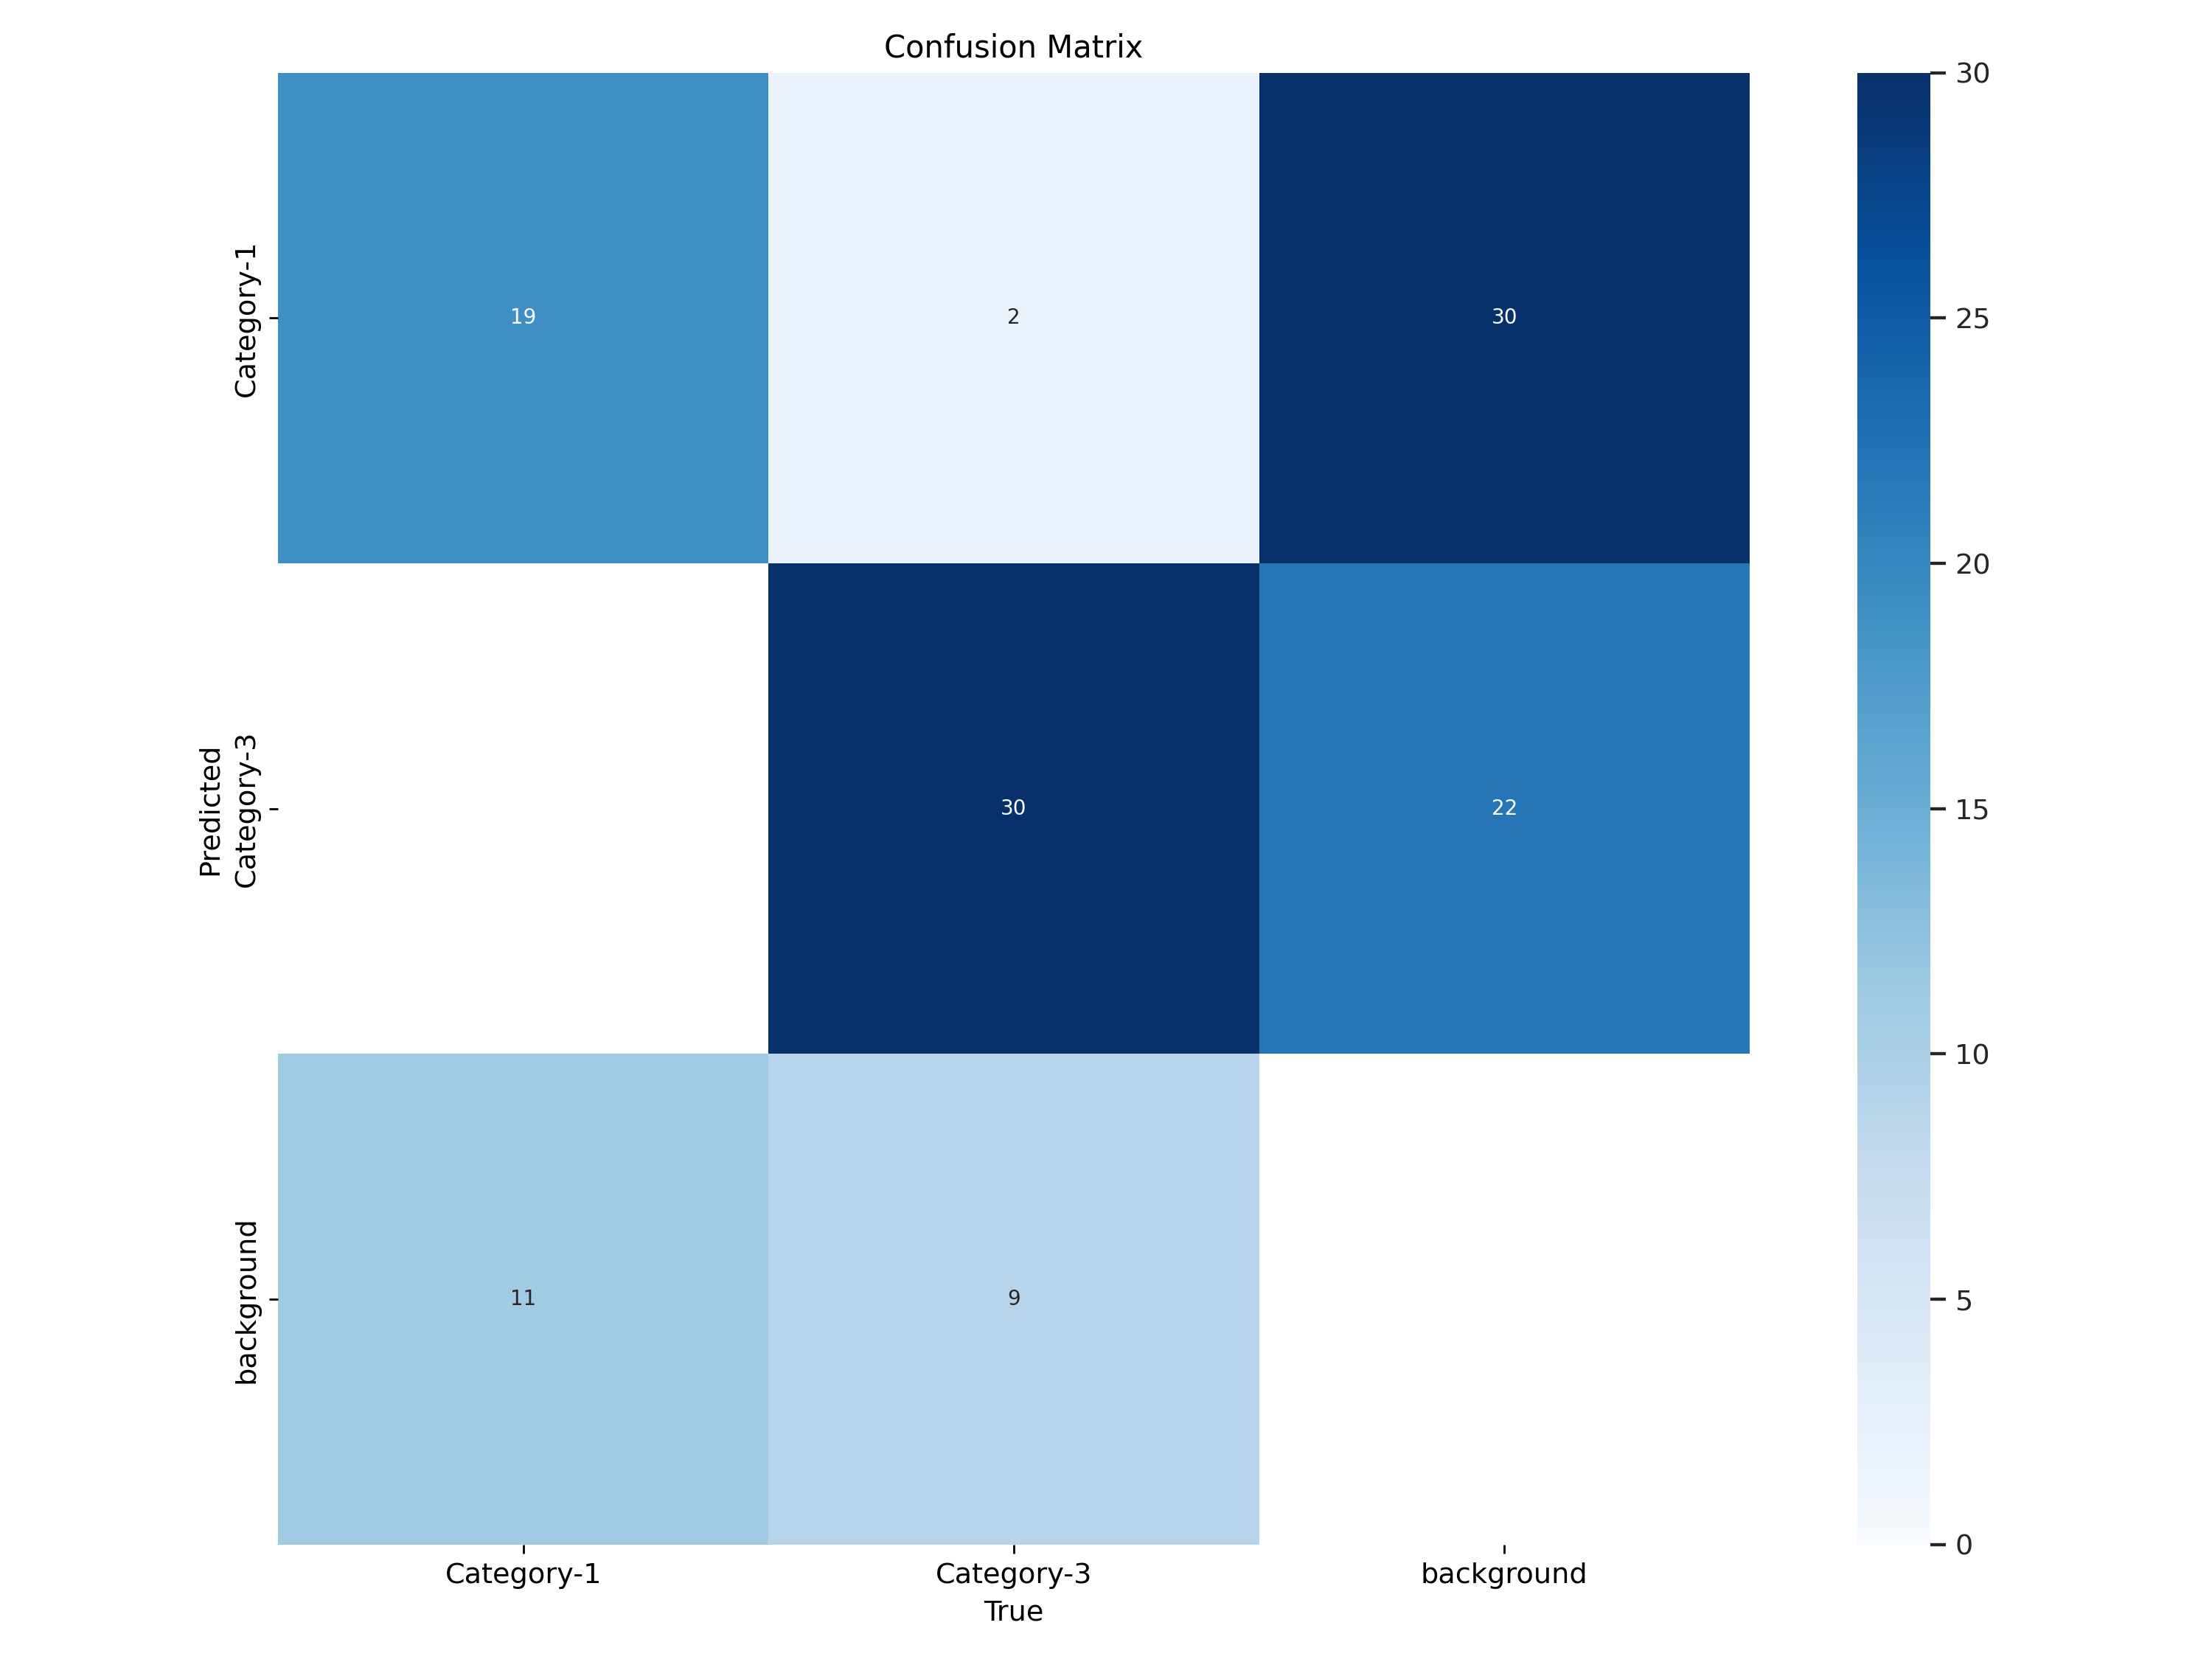

In [16]:
from IPython.display import Image

Image(filename=f'{HOME}/runs/detect/train/confusion_matrix.png', width=1000)

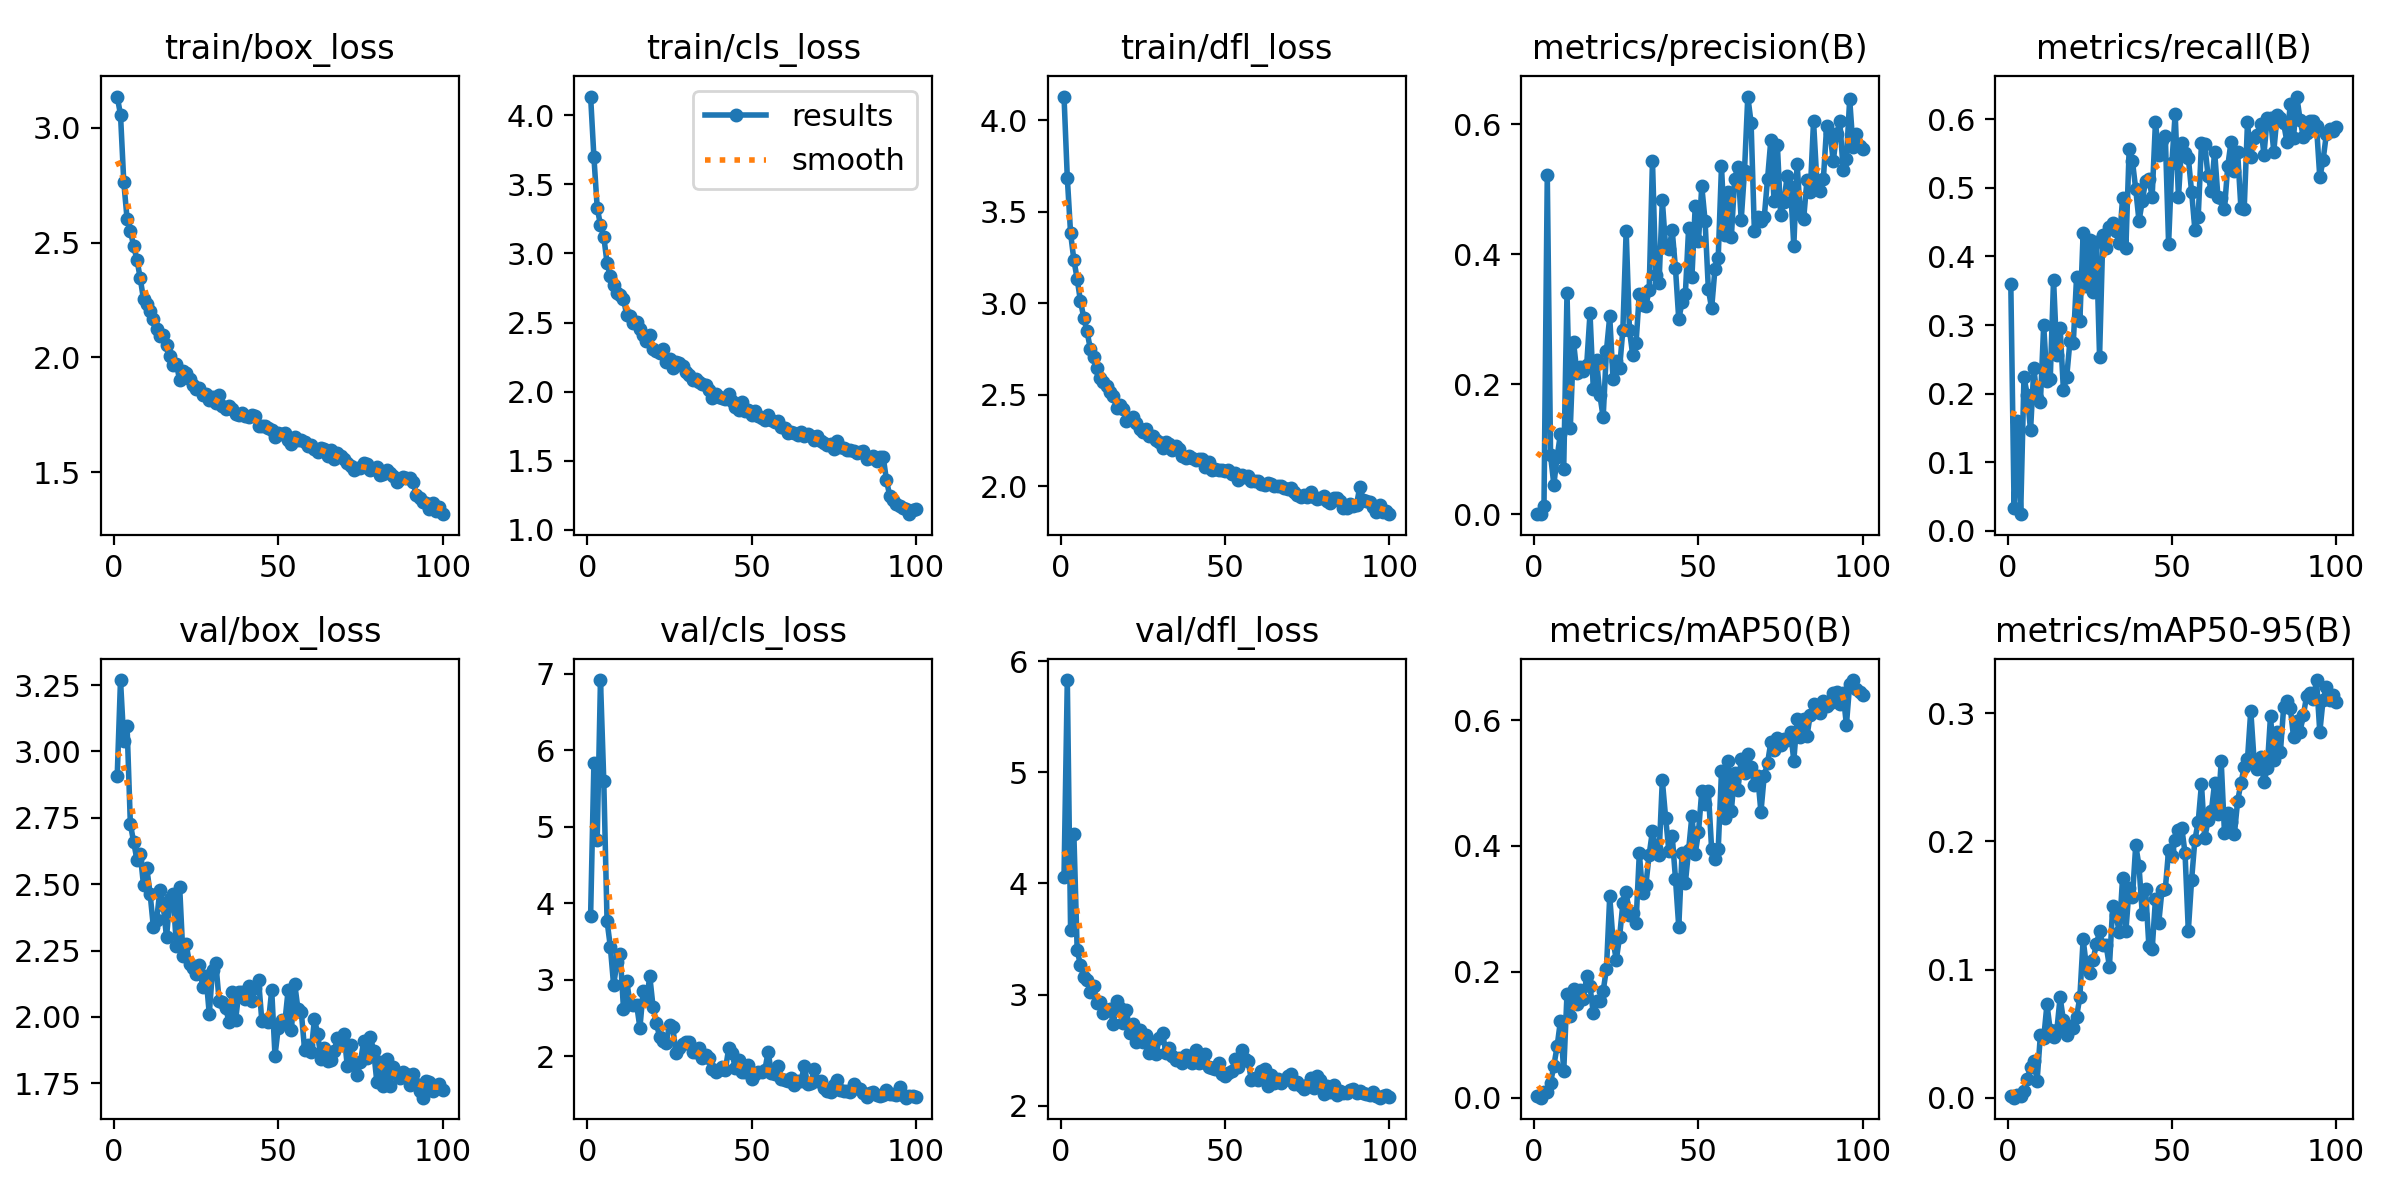

In [17]:
from IPython.display import Image

Image(filename=f'{HOME}/runs/detect/train/results.png', width=1000)

In [18]:
import supervision as sv

ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset.location}/test/images",
    annotations_directory_path=f"{dataset.location}/test/labels",
    data_yaml_path=f"{dataset.location}/data.yaml"
)

ds.classes

['Category-1', 'Category-3']

In [19]:
from supervision.metrics import MeanAveragePrecision

model = YOLO(f'/{HOME}/runs/detect/train/weights/best.pt')

predictions = []
targets = []

for _, image, target in ds:
    results = model(image, verbose=False)[0]
    detections = sv.Detections.from_ultralytics(results)

    predictions.append(detections)
    targets.append(target)

map = MeanAveragePrecision().update(predictions, targets).compute()

In [20]:
print("mAP 50:95", map.map50_95)
print("mAP 50", map.map50)
print("mAP 75", map.map75)

mAP 50:95 0.3215252178902441
mAP 50 0.5821483416926049
mAP 75 0.3377944727245834


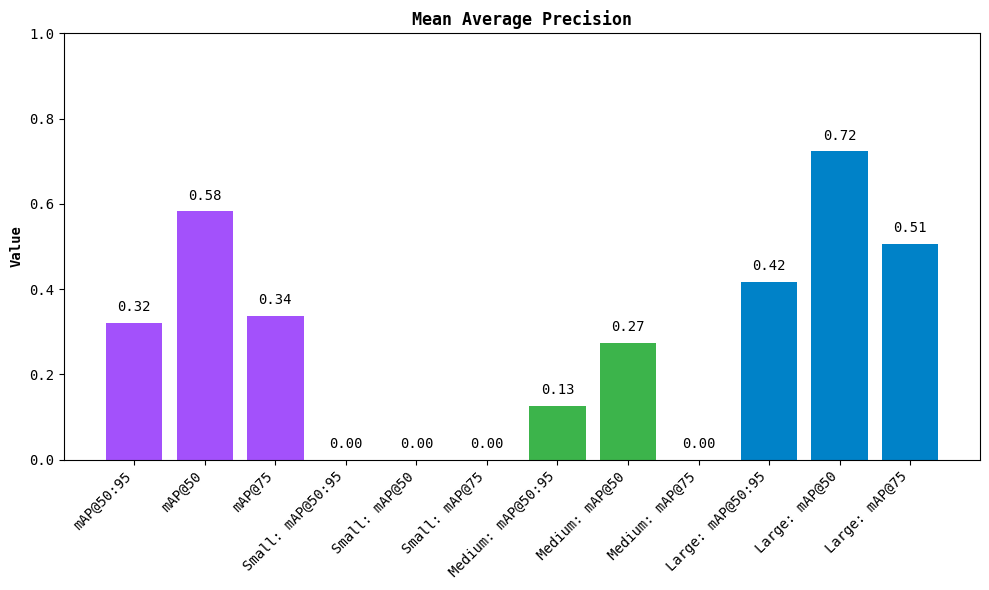

In [21]:
map.plot()

## Run inference with fine-tuned YOLOv12 model

In [22]:
import supervision as sv

model = YOLO(f'/{HOME}/runs/detect/train/weights/best.pt')

ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset.location}/test/images",
    annotations_directory_path=f"{dataset.location}/test/labels",
    data_yaml_path=f"{dataset.location}/data.yaml"
)

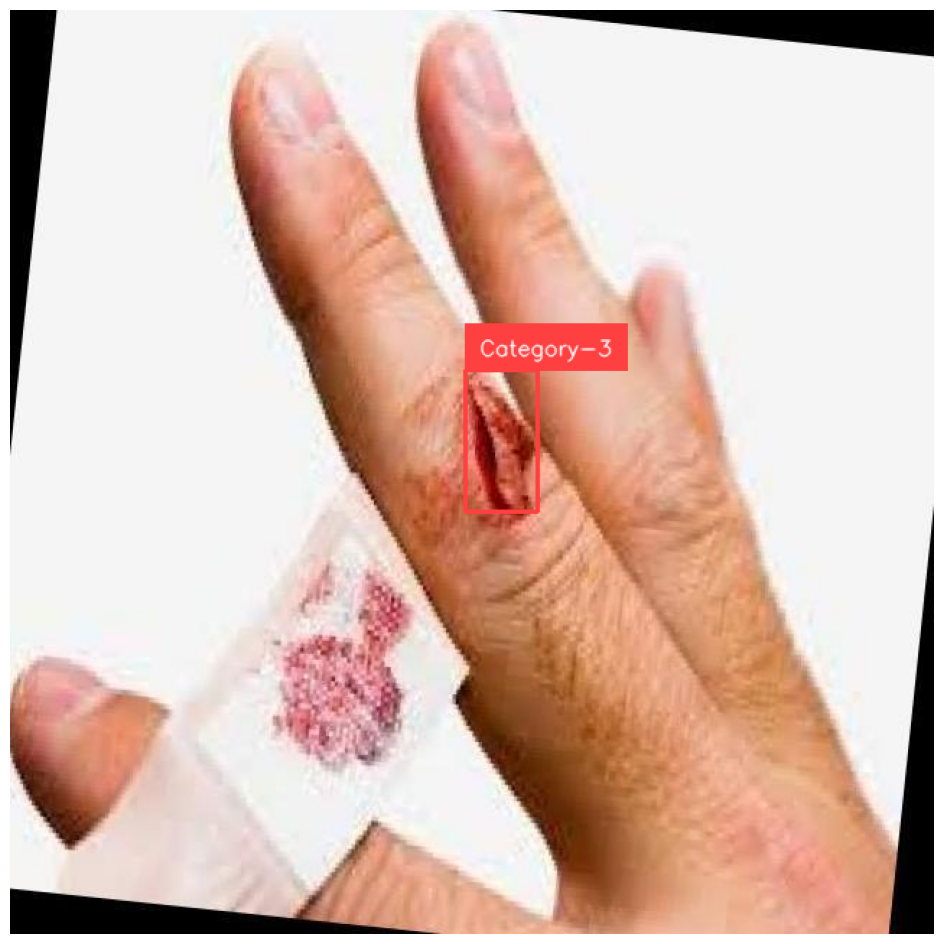

In [23]:
import random

i = random.randint(0, len(ds))

image_path, image, target = ds[i]

results = model(image, verbose=False)[0]
detections = sv.Detections.from_ultralytics(results).with_nms()

box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

annotated_image = image.copy()
annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections)
annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

sv.plot_image(annotated_image)